In [1]:
import pandas as pd

In [2]:
import os.path

In [3]:
import numpy as np

In [4]:
import os

In [5]:
import time
import datetime

In [6]:
import matplotlib.pyplot as plt

In [7]:
from tqdm.notebook import tqdm

In [8]:
import sys

In [9]:
from math import sqrt
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [ ]:
from random import shuffle

## Grouping Stocks

In [10]:
group_path = "/Users/adrianodif/Desktop/stock_groups/"
groups = os.listdir(group_path)

In [11]:
group_df = pd.DataFrame([])
for n,f in enumerate(groups):
    df = pd.read_html(group_path + f)[0]
    df["Sector"] = f.split(".")[0]
    df["Sector_id"] = n
    group_df = pd.concat([group_df,df])

In [12]:
group_df.head()

,Change%,Company,Company.1,Price,Volume,Low,High,Sector,Sector_id
0,▼ -6.09%,AQN,Algonquin Power & Utilities Corp,11.25,1443591,11.17,12.54,utilities,0
1,▼ -14.05%,ALE,"ALLETE, Inc",54.71,873200,53.17,64.44,utilities,0
2,▼ -9.62%,LNT,Alliant Energy Corporation,40.70,3291100,40.21,45.14,utilities,0
3,▼ -12.45%,AEE,Ameren Corporation,62.93,3145800,62.01,71.64,utilities,0
4,▼ -11.58%,AEP,"American Electric Power Company, Inc",71.45,5608800,70.26,81.10,utilities,0


In [13]:
def unixdate(x):
    return datetime.datetime.timestamp(x)

In [172]:
def normaldate(x):
    return datetime.datetime.utcfromtimestamp(x*3600).strftime('%d-%m-%Y')

In [15]:
def smartsort(x):
    try:
        return int(x.split(".")[0])
    except:
        return x.split(".")[0]

In [16]:
csv_path = "../historic_data/csv/"
files = os.listdir(csv_path)
numeric_files = [f for f in files if f.split(".")[0].isnumeric()]
alpha_files = [f for f in files if not f.split(".")[0].isnumeric()]
numeric_files.sort(key=smartsort)
alpha_files.sort(key=smartsort)

In [149]:
min_day = datetime.datetime.strptime("3000-01-01","%Y-%m-%d")
max_day = datetime.datetime.strptime("1900-01-01","%Y-%m-%d") 
max_min_day = datetime.datetime.strptime("1900-01-01","%Y-%m-%d")

In [150]:
n_stocks = 200
min_days = 365*20 

In [ ]:
shuffle(files)

In [155]:
n = 0

selected_files = []

for f in tqdm(files):
    
    if n >= n_stocks:
        continue
        
    st = ".".join(f.split(".")[:-1])
    
    if not st in group_df["Company"].values:
        continue
    df = pd.read_csv(csv_path + f)
    
    df["Date"] = pd.to_datetime(df['Date'])
    
    this_min = df['Date'].min()
    this_max = df['Date'].max()
    
    if (this_max-this_min).days < min_days:
        continue
    
    selected_files.append(f)
    n = n + 1 
    
    max_min_day = max(max_min_day,this_min)
    min_day = min(min_day,this_min)
    max_day = max(max_day,this_max)
    
all_days = pd.date_range(min_day,max_day,freq="1D")

def fill_date(x,col="Date"):
    adf = pd.DataFrame(dict(Date = all_days.difference(pd.Index(x[col]))),columns=x.columns)
    #adf['visit'] = 0
    return x.append(adf,ignore_index=True).sort_values(by=col).bfill()

In [156]:
print("Selected %d stocks"%(len(selected_files)))

Selected 200 stocks


In [157]:
dfs = []
n = 0
for f in tqdm(selected_files):
    
    st = ".".join(f.split(".")[:-1])
    
    if not st in group_df["Company"].values:
        continue

    
    sec_id = group_df[group_df["Company"]==st]["Sector_id"].values[0]
    sec = group_df[group_df["Company"]==st]["Sector"].values[0]
    
    df = pd.read_csv(csv_path + f)
    df["Date"] = pd.to_datetime(df['Date'])
    df["Stock"] = st
    df["Stock_id"] = n
    df["Sector"] = sec
    df["Sector_id"] = sec_id
    
    df["unix_date"] = df["Date"].apply(unixdate)
    df["unix_date"] = (df["unix_date"] - df["unix_date"].min())/3600.0
    df = fill_date(df)
    df = df.sort_values("Date")
    dfs.append(df)
    n = n + 1
    
    
stocks_timeser = pd.concat(dfs,axis=1,)

In [158]:
dfs = []
n = 0
for f in tqdm(selected_files):
    
    st = ".".join(f.split(".")[:-1])
    
    if not st in group_df["Company"].values:
        continue
        
    sec_id = group_df[group_df["Company"]==st]["Sector_id"].values[0]
    sec = group_df[group_df["Company"]==st]["Sector"].values[0]
    
    df = pd.read_csv(csv_path + f)
    df["Stock"] = st
    df["Stock_id"] = n
    df["Sector"] = sec
    df["Sector_id"] = sec_id
    dfs.append(df)
    n = n + 1
    
stocks = pd.concat(dfs)

In [159]:
my_df = stocks
#my_df = stocks

In [160]:
my_df["Date"] = pd.to_datetime(my_df['Date'])

In [161]:
my_df["unix_date"] = my_df["Date"].apply(unixdate)

In [162]:
my_df["unix_date"] = my_df["unix_date"] - my_df["unix_date"].min()
my_df["unix_date"] = my_df["unix_date"]/3600.0

In [163]:
my_df["unix_date"] = my_df["unix_date"] - my_df["unix_date"].min()

In [164]:
my_df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock,Stock_id,Sector,Sector_id,unix_date
0,1995-07-06,11.625,11.75,7806200.0,12.125,12.0625,6.042830,SBGI,0,communication-services,6,223535.0
1,1995-08-06,11.750,11.75,1036400.0,12.125,11.8125,5.917588,SBGI,0,communication-services,6,224279.0
2,1995-09-06,11.750,11.75,702000.0,12.125,11.8750,5.948901,SBGI,0,communication-services,6,225023.0
3,1995-12-06,11.750,11.75,492600.0,12.125,12.0000,6.011519,SBGI,0,communication-services,6,227208.0
4,1995-06-13,11.750,11.75,397800.0,12.125,11.7500,5.886280,SBGI,0,communication-services,6,222983.0


In [165]:
new_df = my_df.groupby("Stock").apply(fill_date)

In [166]:
new_df["unix_date"] = new_df["Date"].apply(unixdate)
new_df["unix_date"] = (new_df["unix_date"] - new_df["unix_date"].min())/3600.0

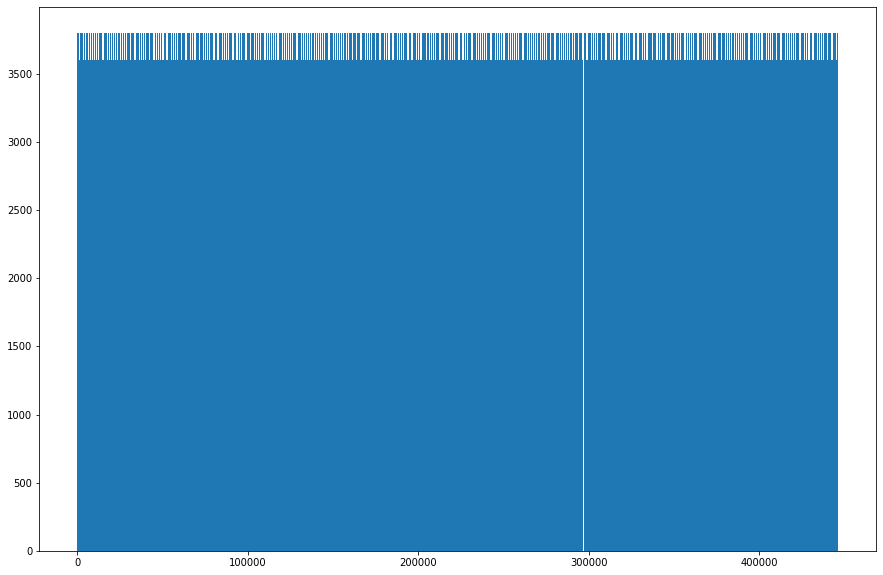

In [171]:
fig = plt.figure(figsize=(15,10))
plt.hist(new_df["unix_date"].values,bins=1000);

In [168]:
new_df.loc[new_df["Open"]==0.0,"Open"] = new_df.loc[new_df["Open"]==0.0,"Low"]

In [169]:
new_df["Var"] = new_df["Close"].values/new_df["Open"].values

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


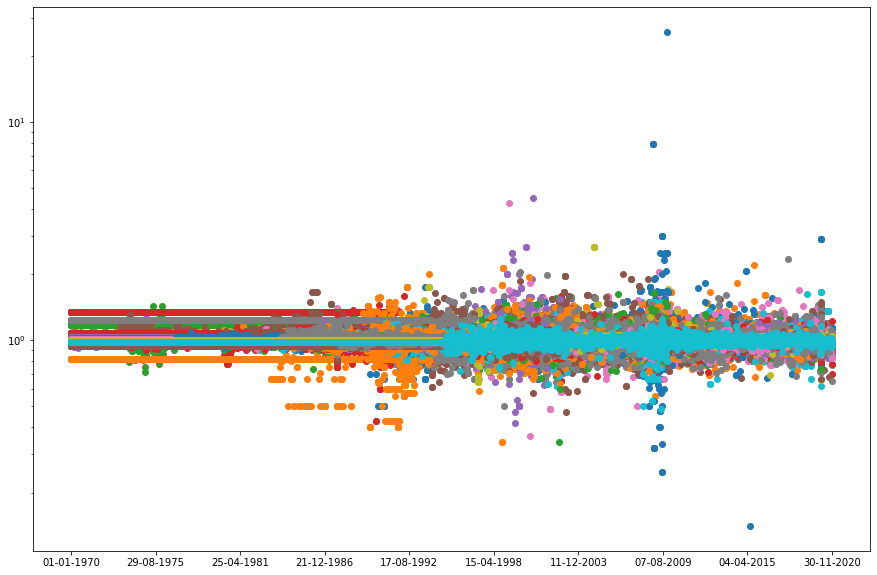

In [173]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
for f in new_df["Stock_id"].value_counts().keys():
    cut = new_df["Stock_id"]==f
    X = new_df[cut]["unix_date"].values
    
    Y = new_df[cut]["Var"]
    plt.plot(X,Y,"o");
  
T = np.linspace(new_df["unix_date"].min(),new_df["unix_date"].max(),10);
plt.yscale("log");
plt.xticks(T,np.vectorize(normaldate)(T));

In [174]:
new_df.head()

Date        Low       Open     Volume       High     Close  \
Stock                                                                         
A     5115 1970-01-04  29.953505  30.177038  2957300.0  31.071173  30.71352   
      5116 1970-01-05  29.953505  30.177038  2957300.0  31.071173  30.71352   
      5117 1970-01-06  29.953505  30.177038  2957300.0  31.071173  30.71352   
      5118 1970-01-07  29.953505  30.177038  2957300.0  31.071173  30.71352   
      5119 1970-01-08  29.953505  30.177038  2957300.0  31.071173  30.71352   

            Adjusted Close Stock  Stock_id      Sector  Sector_id  unix_date  \
Stock                                                                          
A     5115       26.482237     A        45  healthcare          7        0.0   
      5116       26.482237     A        45  healthcare          7       24.0   
      5117       26.482237     A        45  healthcare          7       48.0   
      5118       26.482237     A        45  healthcare          7       72.0   
      5119       26.482237     A        45  healthcare          7       96.0   

                 Var  
Stock                 
A     5115  1.017778  
      5116  1.017778  
      5117  1.017778  
      5118  1.017778  
      5119  1.017778

In [175]:
good_cols = ['Low', 'Open', 'Volume', 'High', 'Close']

In [176]:
num_stocks = stocks["Stock_id"].value_counts().keys().max()+1

In [177]:
stocks_timeser.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock,Stock_id,Sector,...,Open,Volume,High,Close,Adjusted Close,Stock,Stock_id,Sector,Sector_id,unix_date
0,1995-07-06,11.625,11.75,7806200,12.125,12.0625,6.042830,SBGI,0,communication-services,...,0.0,5826200,4.391340,4.350490,-0.004303,SAN,199,financial-services,9,4847.0
1,1995-08-06,11.750,11.75,1036400,12.125,11.8125,5.917588,SBGI,0,communication-services,...,0.0,2104000,4.370915,4.330065,-0.004282,SAN,199,financial-services,9,4871.0
2,1995-09-06,11.750,11.75,702000,12.125,11.8750,5.948901,SBGI,0,communication-services,...,0.0,965600,4.330065,4.319853,-0.004272,SAN,199,financial-services,9,1392.0
3,1995-12-06,11.750,11.75,492600,12.125,12.0000,6.011519,SBGI,0,communication-services,...,0.0,1479800,4.319853,4.227941,-0.004181,SAN,199,financial-services,9,2135.0
4,1995-06-13,11.750,11.75,397800,12.125,11.7500,5.886280,SBGI,0,communication-services,...,0.0,1068400,4.217729,4.105392,-0.004060,SAN,199,financial-services,9,2855.0


In [178]:
cols_timeser = [ f + "_" + str(i) for i in range(num_stocks) for f in stocks.columns ]

In [179]:
stocks_timeser.columns = cols_timeser

In [180]:
redundant = [ f + "_" + str(i) for i in range(1,num_stocks) for f in ["Date","unix_date"] ]
stocks_timeser = stocks_timeser.drop(redundant,axis=1)

In [181]:
good_cols_ser = [ f + "_" + str(i) for i in range(0,num_stocks) for f in good_cols ]

In [182]:
stocks_timeser.head()

,Date_0,Low_0,Open_0,Volume_0,High_0,Close_0,Adjusted Close_0,Stock_0,Stock_id_0,Sector_0,...,Low_199,Open_199,Volume_199,High_199,Close_199,Adjusted Close_199,Stock_199,Stock_id_199,Sector_199,Sector_id_199
0,1995-07-06,11.625,11.75,7806200,12.125,12.0625,6.042830,SBGI,0,communication-services,...,4.319853,0.0,5826200,4.391340,4.350490,-0.004303,SAN,199,financial-services,9
1,1995-08-06,11.750,11.75,1036400,12.125,11.8125,5.917588,SBGI,0,communication-services,...,4.319853,0.0,2104000,4.370915,4.330065,-0.004282,SAN,199,financial-services,9
2,1995-09-06,11.750,11.75,702000,12.125,11.8750,5.948901,SBGI,0,communication-services,...,4.309640,0.0,965600,4.330065,4.319853,-0.004272,SAN,199,financial-services,9
3,1995-12-06,11.750,11.75,492600,12.125,12.0000,6.011519,SBGI,0,communication-services,...,4.227941,0.0,1479800,4.319853,4.227941,-0.004181,SAN,199,financial-services,9
4,1995-06-13,11.750,11.75,397800,12.125,11.7500,5.886280,SBGI,0,communication-services,...,4.084967,0.0,1068400,4.217729,4.105392,-0.004060,SAN,199,financial-services,9


In [200]:
stocks_timeser_skim = stocks_timeser[["unix_date_0","Date_0"] + good_cols_ser]

In [201]:
stocks_timeser_skim = stocks_timeser_skim[1:]

In [202]:
df2 = pd.DataFrame([np.zeros(stocks_timeser_skim.shape[1])], columns=stocks_timeser_skim.columns,index=[-1])
stocks_timeser_skim = pd.concat([df2, stocks_timeser_skim])
stocks_timeser_skim.index = stocks_timeser_skim.index + 1

In [203]:
stocks_timeser_skim.head()

,unix_date_0,Date_0,Low_0,Open_0,Volume_0,High_0,Close_0,Low_1,Open_1,Volume_1,...,Low_198,Open_198,Volume_198,High_198,Close_198,Low_199,Open_199,Volume_199,High_199,Close_199
0,0.0,0,0.00,0.00,0.0,0.000,0.0000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,5039.0,1995-08-06 00:00:00,11.75,11.75,1036400.0,12.125,11.8125,2.034568,2.034568,0.0,...,1.571604,0.0,198700.0,1.623991,1.571604,4.319853,0.0,2104000.0,4.370915,4.330065
3,5783.0,1995-09-06 00:00:00,11.75,11.75,702000.0,12.125,11.8750,2.034568,2.034568,0.0,...,1.571604,0.0,483000.0,1.623991,1.571604,4.309640,0.0,965600.0,4.330065,4.319853
4,7968.0,1995-12-06 00:00:00,11.75,11.75,492600.0,12.125,12.0000,2.034568,2.034568,0.0,...,1.519217,0.0,33200.0,1.571604,1.519217,4.227941,0.0,1479800.0,4.319853,4.227941
5,3743.0,1995-06-13 00:00:00,11.75,11.75,397800.0,12.125,11.7500,2.034568,2.034568,0.0,...,1.493024,0.0,54200.0,1.545410,1.493024,4.084967,0.0,1068400.0,4.217729,4.105392


In [204]:
day_before_columns = ["Low","High","Volume","Close"]
day_before_columns = [ f + "_" + str(i) for i in range(0,num_stocks) for f in day_before_columns ]

In [205]:
stocks_timeser_skim[day_before_columns] = stocks_timeser_skim[day_before_columns].shift(1)

In [206]:
stocks_timeser_skim = stocks_timeser_skim[2:]

In [207]:
stocks_timeser_skim.head(n=-1)

,unix_date_0,Date_0,Low_0,Open_0,Volume_0,High_0,Close_0,Low_1,Open_1,Volume_1,...,Low_198,Open_198,Volume_198,High_198,Close_198,Low_199,Open_199,Volume_199,High_199,Close_199
3,5783.0,1995-09-06 00:00:00,11.750000,11.75,1036400.0,12.125000,11.812500,2.034568,2.034568,0.0,...,1.571604,0.00,198700.0,1.623991,1.571604,4.319853,0.00,2104000.0,4.370915,4.330065
4,7968.0,1995-12-06 00:00:00,11.750000,11.75,702000.0,12.125000,11.875000,2.034568,2.034568,0.0,...,1.571604,0.00,483000.0,1.623991,1.571604,4.309640,0.00,965600.0,4.330065,4.319853
5,3743.0,1995-06-13 00:00:00,11.750000,11.75,492600.0,12.125000,12.000000,2.034568,2.034568,0.0,...,1.519217,0.00,33200.0,1.571604,1.519217,4.227941,0.00,1479800.0,4.319853,4.227941
6,3767.0,1995-06-14 00:00:00,11.750000,11.75,397800.0,12.125000,11.750000,2.034568,0.000000,0.0,...,1.493024,0.00,54200.0,1.545410,1.493024,4.084967,0.00,1068400.0,4.217729,4.105392
7,3791.0,1995-06-15 00:00:00,11.750000,12.25,468200.0,12.750000,12.250000,2.034568,0.000000,36800.0,...,1.519217,0.00,29800.0,1.571604,1.519217,4.115604,0.00,1429600.0,4.217729,4.207516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18592,227040.0,2020-11-26 00:00:00,29.809999,30.25,879000.0,30.889999,30.059999,45.759998,46.849998,40000.0,...,24.610001,24.75,832400.0,24.969999,24.799999,4.230000,4.24,8628800.0,4.260000,4.250000
18593,227040.0,2020-11-27 00:00:00,29.809999,30.25,879000.0,30.889999,30.059999,45.759998,46.849998,40000.0,...,24.610001,24.75,832400.0,24.969999,24.799999,4.230000,4.24,8628800.0,4.260000,4.250000
18594,227040.0,2020-11-28 00:00:00,29.809999,30.25,879000.0,30.889999,30.059999,45.759998,46.849998,40000.0,...,24.610001,24.75,832400.0,24.969999,24.799999,4.230000,4.24,8628800.0,4.260000,4.250000
18595,227040.0,2020-11-29 00:00:00,29.809999,30.25,879000.0,30.889999,30.059999,45.759998,46.849998,40000.0,...,24.610001,24.75,832400.0,24.969999,24.799999,4.230000,4.24,8628800.0,4.260000,4.250000


In [208]:
train_start_date = datetime.datetime.strptime("1995-01-01","%Y-%m-%d")

In [209]:
stocks_timeser_skim = stocks_timeser_skim[stocks_timeser_skim["Date_0"]>train_start_date]

In [210]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [211]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [212]:
# load dataset
values = stocks_timeser_skim.values[:,2:]
# integer encode direction
encoder = LabelEncoder()

In [213]:
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 5, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [214]:
models = {}
histories = {}
tests = {}
RMSEs = {}

In [ ]:
# design network
n_model = 0

for n_days in np.logspace(0.5,2.0,5).astype(int):
    
    if n_days in models:
        continue
    
    call_backs = [
    EarlyStopping(patience=10),
    ModelCheckpoint("model_%d.h5"%n_days,save_best_only=True)
    ]
    
    print("=======================================================")
    print("Testing Model no. %d - predicting from %d days before"%(n_model,n_days))
    print("=======================================================")
    
    print("> Data preprocessing")
    n_model = n_model + 1
    #n_days = 20
    n_features = len(good_cols_ser)
    
    reframed = series_to_supervised(scaled, n_days, 1)

    values = reframed.values
    n_train_days = 365 * 20 #20 years
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]

    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

    print("> Model")
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=1, callbacks=call_backs, shuffle=False)


    tests[n_days] = [test_X,test_y]
    models[n_days] = model
    histories[n_days] = history

Testing Model no. 0 - predicting from 3 days before
> Data preprocessing
> Model
Train on 7300 samples, validate on 1862 samples
Epoch 1/50
7300/7300 [==============================] - 2s 259us/step - loss: 0.1150 - val_loss: 0.1539
Epoch 2/50
7300/7300 [==============================] - 1s 202us/step - loss: 0.1023 - val_loss: 0.1391
Epoch 3/50
7300/7300 [==============================] - 1s 203us/step - loss: 0.0938 - val_loss: 0.2074
Epoch 4/50
7300/7300 [==============================] - ETA: 0s - loss: 0.077 - 1s 202us/step - loss: 0.0776 - val_loss: 0.2900
Epoch 5/50
7300/7300 [==============================] - 1s 204us/step - loss: 0.0924 - val_loss: 0.1999
Epoch 6/50
7300/7300 [==============================] - 1s 205us/step - loss: 0.0672 - val_loss: 0.3804
Epoch 7/50
7300/7300 [==============================] - 2s 207us/step - loss: 0.0735 - val_loss: 0.1963
Epoch 8/50
7300/7300 [==============================] - 2s 208us/step - loss: 0.0615 - val_loss: 0.1637
Epoch 9/50
7300

7300/7300 [==============================] - 8s 1ms/step - loss: 0.0727 - val_loss: 0.1394
Epoch 12/50
7300/7300 [==============================] - 7s 945us/step - loss: 0.0653 - val_loss: 0.1478
Epoch 13/50
7300/7300 [==============================] - 8s 1ms/step - loss: 0.0577 - val_loss: 0.0804
Epoch 14/50
7300/7300 [==============================] - 6s 847us/step - loss: 0.0534 - val_loss: 0.0552
Epoch 15/50
7300/7300 [==============================] - 6s 888us/step - loss: 0.0562 - val_loss: 0.1534
Epoch 16/50
7300/7300 [==============================] - 7s 902us/step - loss: 0.0472 - val_loss: 0.0982
Epoch 17/50
7300/7300 [==============================] - 7s 992us/step - loss: 0.0432 - val_loss: 0.0824
Epoch 18/50
7300/7300 [==============================] - 6s 824us/step - loss: 0.0455 - val_loss: 0.0806
Epoch 19/50
7300/7300 [==============================] - 7s 928us/step - loss: 0.0398 - val_loss: 0.1534
Epoch 20/50
7300/7300 [==============================] - 6s 816us/step 

7300/7300 [==============================] - 39s 5ms/step - loss: 0.0508 - val_loss: 0.0937
Epoch 16/50
 320/7300 [>.............................] - ETA: 31s - loss: 0.0613

In [ ]:
n_keys=len(histories)
theLs = list(histories.keys())

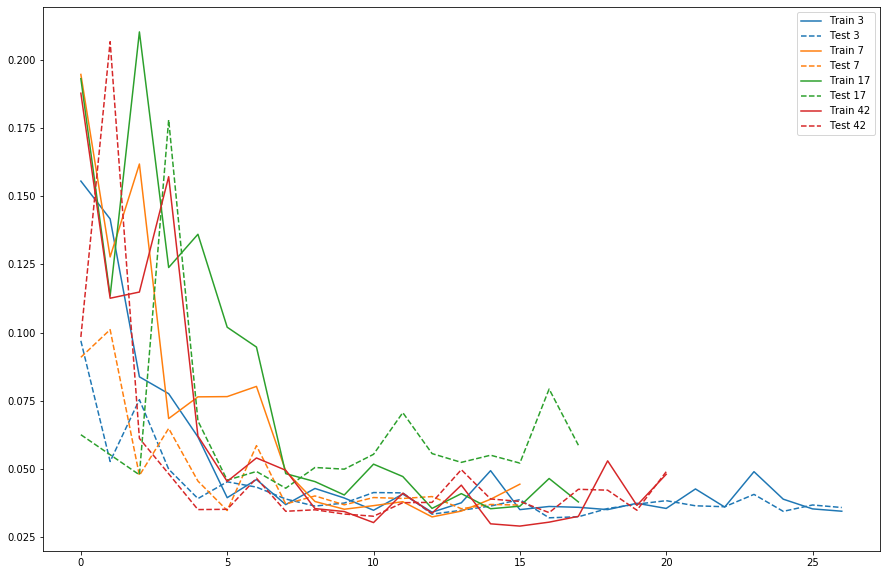

In [103]:
colors = [""]
plt.figure(figsize=(15,10))

for k,n in zip(histories,theLs): 
    history = histories[k]
    train_loss = plt.plot(history.history['loss'],"-", label='Train %d'%(n))[0]
    plt.plot(history.history['val_loss'],"--",color=train_loss.get_color(),label='Test %d '%(n))
    
plt.legend()
plt.show()

In [120]:
from keras.models import load_model

In [123]:
for k in tests: 
    
    #model = models[k]
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    model = load_model("model_100 8.h5")
    #print(test.shape)
    test_X = tests[k][0]
    text_y = tests[k][1]
    
    #print(model.summary())
    yhat = model.predict(test_X)
    
    RMSEs[k] = sqrt(mean_squared_error(test_y, yhat[yhat.shape[0]-test_y.shape[0]:]))
    
    
    #train_loss = plt.plot(history.history['loss'],"-", label='Train %d'%(n))[0]
    #plt.plot(history.history['val_loss'],"--",color=train_loss.get_color(),label='Test %d '%(n))


ValueError: Error when checking input: expected lstm_6_input to have shape (100, 1150) but got array with shape (3, 1150)

No handles with labels found to put in legend.


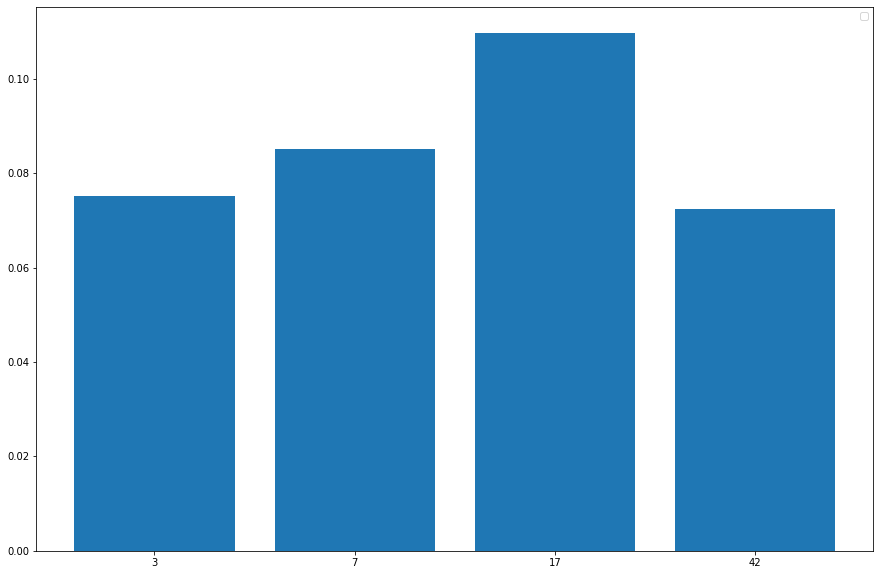

In [101]:
plt.figure(figsize=(15,10))
plt.bar(range(n_keys),RMSEs.values())
plt.xticks(range(n_keys),labels=list(RMSEs.keys()))
plt.legend()
plt.show()

In [503]:
# design network
n_model = 0

for n_days in np.linspace(7,13,7).astype(int):
    print("=======================================================")
    print("Testing Model no. %d - predicting from %d days before"%(n_model,n_days))
    print("=======================================================")
    
    n_model = n_model + 1
    #n_days = 20
    n_features = len(good_cols_ser)

    reframed = series_to_supervised(scaled, n_days, 1)

    values = reframed.values
    n_train_hours = 365 * 30 #30 years
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))


    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    history = model.fit(train_X, train_y, epochs=50, batch_size=256, validation_data=(test_X, test_y), verbose=0, callbacks=call_backs, shuffle=False)


    tests[n_days] = [test_X,test_y]
    models[n_days] = model
    histories[n_days] = history

Testing Model no. 0 - predicting from 7 before
Testing Model no. 1 - predicting from 8 before
Testing Model no. 2 - predicting from 9 before
Testing Model no. 3 - predicting from 10 before
Testing Model no. 4 - predicting from 11 before
Testing Model no. 5 - predicting from 12 before
Testing Model no. 6 - predicting from 13 before


In [507]:

for k,k1 in zip(models,tests): 
    
    model = models[k]
    test = tests[k]
    #print(test.shape)
    test_X = test[0]
    text_y = test[1]
    
    #print(model.summary())
    yhat = model.predict(test_X)
    
    RMSEs[k] = sqrt(mean_squared_error(test_y, yhat[yhat.shape[0]-test_y.shape[0]:]))
    
    
    #train_loss = plt.plot(history.history['loss'],"-", label='Train %d'%(n))[0]
    #plt.plot(history.history['val_loss'],"--",color=train_loss.get_color(),label='Test %d '%(n))



No handles with labels found to put in legend.


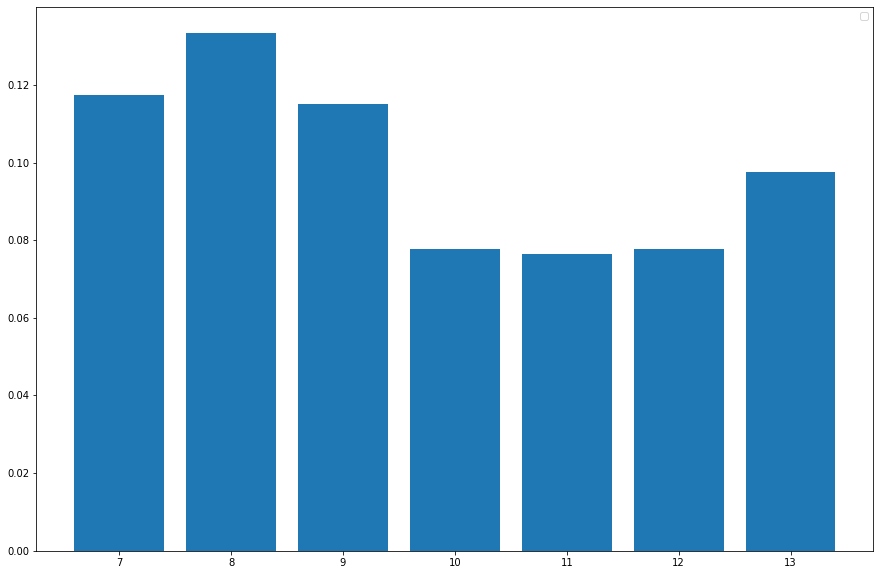

In [510]:
plt.figure(figsize=(15,10))
plt.bar(models.keys(),RMSEs.values())
#plt.xticks(np.linspace(0.0,10.0,10),np.logspace(0.5,2.0,10).astype(int))
plt.legend()
plt.show()

[[1.         0.60772668]
 [0.60772668 1.        ]]
[[1.         0.09314619]
 [0.09314619 1.        ]]
[[ 1.         -0.30017735]
 [-0.30017735  1.        ]]
[[1.         0.60440968]
 [0.60440968 1.        ]]


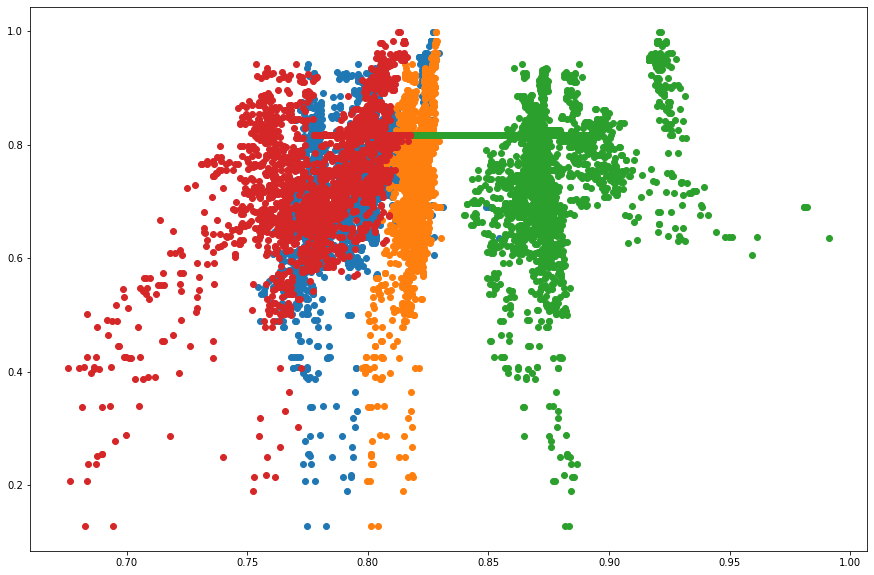

In [105]:
plt.figure(figsize=(15,10))

for k in models: 
    
    model = models[k]
    test = tests[k1]
    #print(test.shape)
    test_X = test[0]
    text_y = test[1]
    
    #print(model.summary())
    yhat = model.predict(test_X)
    
    print(np.corrcoef(yhat[yhat.shape[0]-test_y.shape[0]:,0],test_y))
    plt.plot(yhat[yhat.shape[0]-test_y.shape[0]:],test_y,"o")

In [521]:
.shape

(3982,)

In [516]:
test_y.shape

(3982,)